<img align='center' src='https://www.unidformazione.com/wp-content/uploads/2018/04/unipd-universita-di-padova.png' alt='Drawing' style='width:300px;'/>

# Advanced Statistics for Physics Analysis a.a. 2020-2021
<h2 align='left'>University of Padua - Physics of Data</h2>
<h3 align='right'>Prof. Alberto Garfagnini</h3>

***

### Francesca Dodici - Samuele Piccinelli - Cristina Venturini

## Learning the topology of a bayesian network from a database of cases using the K2 algorithm

> A Bayesian belief-network structure is a directed acyclic graph in which nodes represent domain variables and arcs between nodes represent probabilistic dependencies [**1**]. 
Given a database of records, it is interesting to construct a probabilistic network which can provide insights into probabilistic dependencies existing among the variables in the database. Such network can be further used to classify future behaviour of the modelled system [**1**]. 
Although researchers have made substantial advances in developing the theory and application of belief networks, the actual construction of these networks often remains a difficult, time consuming task. An efficient method for determining the relative probabilities of different belief-network structures, given a database of cases and a set of explicit assumptions is described in [**1**] and [**2**].
The **K2 algorithm** [**2**] can be used to learn the topology of a Bayes network [**1**], i.e. of finding the most probable belief-network structure, given a database.

**Part 1** After having studied the problem in the suggested literature ([**1**]-[**2**]), Implement the algorithm in R and check its performances with the test data set given in [**2**].

**Part 2** Implement and test the K2 algorithm with the test data sets [**2**]. Investigate if it is possible to code it inside the bnstruct R package [**3**]-[**4**].

<a id='index'></a>
## Index

1. [Theoretical background ](#theo)
2. [The K2 Algorithm](#K2)<br>
      2.1 [Auxiliary functions](#aux)<br>
      2.1 [Our implementation](#imp)<br>     
3. [Expectations of network conditional probabilities](#exp)
4. [Testing the algorithm](#test)<br>
      4.1 [Ruiz dataset](#ruiz)<br>
      4.2 [`bnstruct`'s `asia` dataset](#asia)<br>
      4.3 [`bnstruct`'s `child` dataset](#child)<br>
5. [Code performances](#performances)
6. [K2 in `bnlearn`: `asia` and `child` datasets](#bnlearn)<br>
      6.1 [`asia` dataset](#abnlearn)<br>
      6.2 [`child` dataset](#cbnlearn)<br>
7. [Implementing K2 in `bnstruct`](#k2bnstruct)
8. [Conclusion and Outlook](#out)
9. [References](#ref)

<a id='theo'></a>
[Index](#index)
## 1. Theoretical background 

***

A **Bayesian belief-network structure** $B_s$ is a directed acyclic graph in which nodes represent domain variables and arcs between nodes represent probabilistic dependencies. 
A variable in a Bayesian belief-network structure may be continuous or discrete. Since the algorithm we want to implement is designed to work with discrete variables, we shall focus our discussion on the latter case.

$B_s$, is augmented by **conditional probabilities**, $B_e$, to form a **Bayesian belief network** $B = (B_s, B_e)$. For brevity, we shall refer to $B$ as a **BBN**. For each node $i$ in a belief-network structure, there is a conditional-probability function that relates this node to its immediate predecessors (parents). We shall use $\pi_i$ to denote the parent nodes of variable $x_i$.

BBNs are capable of representing the probabilities over any discrete sample space since the probability of any sample point in that space can be computed from the probabilities in the belief network. The key feature of BBNs is their explicit representation of the conditional independence and dependence among events. In particular, it has been proved that the joint probability of any particular instantiation of all $n$ variables in a BBN can be calculated as follows:

$$
P(X_1,X_2,...,X_n)=\prod_{i=1}^{n}P(X_{i}|\pi_{i}) \qquad \qquad (1)
$$

where $X_i$ represents the instantiation of variable $x_i$ and $\pi_i$ represents the instantiation of the parents of $x_i$.

***

Let us now consider the problem of **finding the most probable belief-network structure** $B_s$, given a database of cases $D$.
Let's call $Z$ the set of variables represented by $D$, and $B_{si}, B_{sj}$ two possible belief-network structures containing exactly those variables in $Z$. 

By computing the ratios $\frac{P(B_{si}|D)}{P(B_{sj}|D)}$ for different possible pairs of belief-network structures, we can rank order a set of structures by their posterior probabilities. To calculate this ratio of posterior probabilities, we can  calculate $P(B_{si}, D)$ and $P(B_{sj}, D)$ and use the following equivalence:

$$
\frac{P(B_{si}|D)}{P(B_{sj}|D)}= \frac{\frac{P(B_{si}|D)}{P(D)}}{\frac{P(B_{sj}|D)}{P(D)}} =\frac{P(B_{si},D)}{P(B_{sj},D)}\qquad \qquad (2)
$$

Besides, we can determine $P(B_s, D)$. By making the following assumptions:

1. The database variables, which we denote as $Z$, are discrete;
2. Cases occur independently, given a belief-network model; (e.g if a coin is believed with certainty to be fair, then the fact that the first flip landed heads (case 1) does not influence our belief that the second flip (case 2) will land heads.)
3. There are no cases that have variables with missing values which is not usually true but we assume this for the sake of simplicity
4. Prior to the observation of the database $D$, the numerical probabilities to place on belief-network structure $B_s$ are indifferent.

Given these assumptions, the following theorem can be proved:
#### Theorem (proof in appendix of [1])
>Let $Z$ be a set of $n$ variables, where a variable $x_i$ in $Z$ has $r_i$ possible value assignments: ($\nu_{i_1}$,...,$\nu_{ir_i}$). Let $D$ be a database of $m$ cases, where each case contains a value assignment for each variable in $Z$. Each variable $x_i$ in $B_{S}$ has a set of parents, which we represent with a list of variables $\pi_{i}$. Let $w_{ij}$ denote j-th unique instantiation of $\pi_{i}$, relative to $D$. Suppose there are $q_i$ such unique instantiations of $\pi_{i}$. Define $\alpha_{ijk}$ to be the number of cases in $D$ in which variable $x_i$ has the value $\nu_{ik}$ and $\pi_{i}$ is instantiated as $w_{ij}$. Let
$$
N_{ij}=\sum_{k=1}^{r_{i}}\alpha_{ijk}
$$
Given the assumptions 1 through 4 it follows that:
$$
P(B_s,D)=P(B_s)\prod_{i=1}^{n}\prod_{j=1}^{q_i}\frac{(r_i-1)!}{(N_{ij}+r_i-1)!}\prod_{k=1}^{r_i}\alpha_{ijk}! \qquad \qquad (3)
$$

In light of what we discussed, we now want to determine the most probable belief-network structure given a database $D$, i.e. the $B_s$ that maximizes $P(B_s|D)$. 
Since according to eq. (2), $P(B_s, D) \propto P(B_s|D)$, finding the $B_s$ that maximizes $P(B_s|D)$ is equivalent to finding the $B_s$ that maximizes $P(B_s, D)$. 

The most straightforward idea one can think of is to maximize $P(B_s, D)$ by simply applying equation (3) exhaustively for every possible $B_s$. Of course the main issue when doing so is that the number of possible structures grows exponentially as a function of the number of nodes.
For example, using an efficiently computable recursive function for determining the number of possible $B_s$ with $n$ nodes derived by Robinson in 1977

$$
f(n)=\sum_{i=1}^{n}(-1)^{i+1}{n\choose i}2^{i(n-1)}f(n-i) \qquad \qquad (4)
$$

we find that we would have $\sim 4.2\cdot 10^{18}$ structures for $n=10$. Clearly, there is a need of implementing a method for locating the $B_s$ that maximizes $P(B_s|D)$ more efficiently than exhaustive enumeration.

***
Firstly, to reduce the time complexity of the method Cooper and Herskovits introduced some additional assumptions and conditions to simplify the problem. The complexity of the task, however, remains exponential. Thus, the authors also realized a modified algorithm to construct a heuristic method with polynomial time complexity.

### - Exact methods

#### 1. Ordering of nodes
First of all let's assume, that we can specify an ordering on all $n$ variables such that, if $x_i$ precedes $x_j$ in the ordering, then we do not allow structures in which there is an arc from $x_j$ to $x_i$. 
Given such an ordering as a constraint, there remain $2^{n\choose 2}=2^{\frac{n(n-1)}{2}}$ possible $B_s$. For large $n$, it is still not feasible to apply equation (2) for each of them. 

#### 2. Equal priors
In addition to a node ordering, the authors also assumed equal priors on $B_s$. That is, initially, before the observation of $D$, we assume that all structures are equally likely. In that case, we obtain:

$$
P(B_s,D)= c \prod_{i=1}^{n}\prod_{j=1}^{q_{i}}\frac{(r_{i}-1)!}{(N_{ij}+r_{i}-1)}\prod_{k=1}^{r_{i}}\alpha_{ijk}! \qquad \qquad (5)
$$

where c is the constant prior probability $P(B_s)$, for each $B_s$. Thus, to maximize equation (5), we need only to find the parent set of each variable that maximizes the second inner product.

$$
max_{B_S}[P(B_{S},D)]=c\prod_{i=1}^{n}max_{\pi_{i}}\left[\prod_{j=1}^{q_{i}}\frac{(r_{i}-1)!}{(N_{ij}+r_{i}-1)}\prod_{k=1}^{r_{i}}\alpha_{ijk}!\right] \qquad \qquad (6)
$$

#### 3. Upper limit on number of parents
Finally, to further improve the time complexity of computing eq.(6) one can assume that a node can have at most $u$ parents.

***
### - Euristic method: the K2 algorithm

Cooper and Herskovits then proposed a heuristic-search method, for maximizing $P(B_s, D)$: the **K2 algorithm**. 
It is a greedy-search method in which the algorithm begins by making the assumption that a node has no parents, and then proceeds by adding, one at a time, new parents whose addition most increases the probability of the resulting structure. We stop adding parents to the node when no further addition of a single parent can increase the probability.

Starting from eq.(6) with all the assumptions mentioned so far, we can use the following function to quantify the probability of the database $D$ given that the parents of $x_i$ are $\pi_i$:

$$
f(i,\pi_i)=\prod_{j=1}^{q_{i}}\frac{(r_{i}-1)!}{(N_{ij}+r_{i}-1)}\prod_{k=1}^{r_{i}}\alpha_{ijk}! \qquad \qquad(7)
$$

The algorithm works as follows:

```Python
1. procedure K2;
2. # {Input: A set of n nodes, an ordering on the nodes, an upper bound u on the
3. # number of parents a node may have, and a database D containing m cases.}
4. # {Output: For each node, a printout of the parents of the node.}
5. for i:= 1 to n do
6.   𝜋𝑖  := Ø;
7.   P_old := f(i, 𝜋i); #{This function is computed using Equation 7}.
8.   OKToProceed := TRUE;
9.   While OKToProceed and |𝜋i| < u do
10.     let z be the node in Pred(xi) - 𝜋i that maximizes f(i, 𝜋i Ս {z});
11.     P_new := f(i, 𝜋i Ս {z});
12.     if P_new > P_old then
13.       P_old := P_new;
14.       𝜋i := 𝜋i Ս {z};
15.     else OKToProceed := FALSE;
16.   end {while};
17.   write('Node:', xi, 'Parent of xi:', 𝜋i);
18.  end {for};
19. end {K2};
```

***

Having found the most probable belief-network structure we can now derive the **expectation values of network conditional probabilities** (given the database and the belief-network structure). 

Let's define the *network conditional probability* $\theta_{ijk}$ as the conditional probability $P(x_i = \nu_{ik} | \pi_i = w_{ij})$ that is, the probability that $x_i$ has value $\nu_{ik}$, for some $k$ from 1 to $r_i$, given that the parents of $x_i$, represented by $\pi_i$, are instantiated as $w_{ij}$. Let us also denote the four assumptions previously made as $\xi$. It can be proved (theorem 2 in appendix of [**1**]) that the Bayes' estimator of $\theta_{ijk}$ can be computed as:

$$
\mathbb{E}[\theta_{ijk}|D,B_s, \xi]=\mathbb{E}[P(x_i=v_{ik}|\pi_i=w_{ij})]=\frac{\alpha_{ijk}+1}{N_{ij}+r_i}  \qquad \qquad(8)
$$

and its variance:

$$
Var[\theta_{ijk}|D,B_s, \xi]=Var[P(x_i=v_{ik}|\pi_i=w_{ij})]=
\frac{(\alpha_{ijk}+1)(N_{ij}+r_i-\alpha_{ijk}-1)}{(N_{ij}+r_i)^2(N_{ij}+r_i+1)}  \qquad \qquad(9)
$$

## Load required packages

In [ ]:
# install.packages('bnstruct', repo='https://cran.stat.unipd.it/')
# install.packages('bnlearn', repo='https://cran.stat.unipd.it/')

In [1]:
# libraries and useful dependecies
suppressMessages(library(data.table))
suppressMessages(library(plyr))

suppressMessages(library(combinat))
suppressMessages(library(purrr))
suppressMessages(library(dplyr))
suppressMessages(library(igraph))
suppressMessages(library(intergraph))

suppressMessages(library(bnstruct))
suppressMessages(library(bnlearn))

suppressMessages(library(ggplot2))
suppressMessages(library(GGally))
suppressMessages(library(sna))

suppressMessages(library(corrplot))

In [2]:
# plot settings
options(repr.plot.width=6, repr.plot.height=4)
theme_set(theme_bw() + theme(text=element_text(family='Times New Roman', size=12), panel.border = element_blank(),
          legend.text=element_text(size=12), legend.background=element_rect(size=0.3, linetype='solid',colour='black')))

<a id='K2'></a>
[Index](#index)
## 2. The K2 Algorithm

We now present our implementation of the K2 algorithm in R. The input database $D$ is stored in a datatable and then analyzed using the functions defined in this section. 
Since the algorithm requires the calculation of factorials of very large numbers, to avoid overflow issues a logarithmic version of the code is also implemented and should be used when dealing with datasets having many cases. In this 'logversion' (which is called by default when the boolean variable `flog` is set to TRUE) `factorial()` is replaced with `lfactorial()` and the products `prod()` with summations `sum()`.

<a id='aux'></a>
### 2.1 Auxiliary functions

Let's start by defining three auxiliary functions that will then be called in the K2 algorithm when needed.

#### `r`

* **Input**
    - `df`: Name of datatable storing the database 
* **Output**
    - Vector containing the cardinality of the set of all possible instantiations for each node.

This function takes as input the datatable containing our database $D$ and determines, for each node, the number of unique values assumed throughout all cases of the database $D$.

#### `params`

* **Input**
    - `df`: Name of datatable storing the database 
    - `par`: string with the name of the parent of the considered node   
    - `son`: string with the name of the considered node
    - `flog`: bool set to FALSE for the normal computation whereas TRUE is set to work with the logversion of the code  
    
* **Output**
    - `alpha`: $\prod_{j=1}^{q_{i}}\prod_{k=1}^{r_{i}}\alpha_{ijk}!$
    - `N_j`: $\sum_{k=1}^{r_{i}}\alpha_{ijk}$

This function takes as input the datatable containing the database $D$ and then, considering the parent-son pair given as input, it computes the frequency in $D$ of all possible instantiations (i.e. the values of all possible $\alpha_{ijk}$ for node $i$).
Then it computes, and returns, $\prod_{j=1}^{q_{i}}\prod_{k=1}^{r_{i}}\alpha_{ijk}!$ (or the sum of the logfactorials for big datasets).<br>
In order to return the correct values of $\alpha_{ijk}$, special care must be put into ordering the datatable in the correct way. <br> 
Finally, by performing a marginalization over the possible values of the variable in the node ($k=1,...,r_i$ where $r_i$ is determined using the function `r`), it computes and returns $N_{ij}$. 

#### `f`

* **Input**
    - `par`: Known parents of the node considered
    - `df`: Name of datatable storing the database  
    - `i`: Index of considered node 
    - `nod`: List of all nodes of the network 
    - `flog`: bool set to FALSE for the normal computation whereas TRUE is set to work with the logversion of the code  
    
* **Output**
    - The score $f(i,\pi_i)$ defined in eq. (7) for the i-th node assuming its parents are `p_i`

This function is the heart of the K2 algorithm as it is used to compute the probability of the assumed connections for our node given the database $D$. Making use of the input quantities, the function simply computes the result of eq. (7) and returns it as output.

In [3]:
r <- function(df){
    return(rapply(df, function(x)length(unique(x))) %>% unname)
}

In [4]:
params <- function(df, par, son, flog=TRUE){

    tmp  <- df[, c(par, son), with=FALSE] %>% table %>% as.data.frame
    if (!identical(par,NULL)) for (i in length(par):1) tmp <- tmp[order(tmp[, i]),]

    freq <- tmp %>% pull(Freq)

    r_i  <- r(df)[which(colnames(data)==son)]
    if (flog) alpha <- freq %>% lfactorial %>% sum else alpha <- freq %>% factorial %>% prod
    
    N_j  <- freq %>% matrix(, nrow = r_i) %>% colSums

    return(c(alpha, N_j))
}

In [5]:
f <- function(par, df, i, nod, flog=TRUE){
    son   <- nod[i]
    aN    <- params(df, par, son, flog)
    alpha <- aN[1]
    Ns    <- aN[-1]
    r_i   <- r(df)[i]
    
    if (flog){
        num <- (lfactorial(r_i-1))*length(Ns)
        den <- lfactorial(Ns+r_i-1) %>% sum
        
        return(num - den + alpha)
    } else{
        num <- (factorial(r_i-1))^length(Ns)
        den <- factorial(Ns+r_i-1) %>% prod
        
        return(num*alpha/den) 
    }
}

<a id='imp'></a>
### 2.2 Our implementation

We can now proceed to translate the pseudo-code previously reported defining the K2 algorithm into real R code.

#### `K2`

* **Input**
    - `nodes`: Vecotr of all names of the nodes of the network
    - `level`: Vector codifying the ordering of the nodes
    - `u`: Upper limit for the number of possible parents of a node
    - `df`: Name of datatable storing the dataset
    - `flog`: bool set to FALSE for the normal computation whereas TRUE is set to work with the logversion of the code  
    
* **Output**
    - Printout of all parents of each node of the network
    - Printout of the global score of the final network (determined by summing over all nodes the final values of $f(i,\pi_i)$)
    - `adj`: The resulting adjacency matrix
    
This function implements the K2 algorithm in a general way: the input network can have an arbitrary number of nodes, with no restrictions on the cardinality of the set of values the node can have. <br>
The function returns the adjacency matrix, which stores information about son-parents groups in a compact way as follows: 

$$ adj_{ij}=   \left\{
\begin{array}{lll}
      1 && \text{if j-th node is a parent of the i-th one}\\
      0 && \text{otherwise}  \\
\end{array} 
\right.  
$$

In [6]:
K2 <- function(nodes, level, u, df, flog=TRUE){
    n     <- length(nodes)
    score <- double(length(nodes))
    adj   <- matrix(0,nrow=n,ncol=n)
    rownames(adj) <- nodes; colnames(adj) <- nodes
    for (i in 1:n){
#         cat('Iteration:',i,'\n')
        p_i     <- NULL
        P_old   <- f(p_i, df, i, nodes, flog)
        proceed <- TRUE
        
        t <- data.table(cbind(level, nodes))
        while (proceed & length(p_i) < u){
            pred    <- t[t$level < t$level[i]] %>% pull(nodes)
            if (identical(pred, character(0)) | identical(pred, p_i)) break
            z_cand  <- pred[! pred %in% p_i]
            
            if (identical(p_i, NULL)){
                args    <- z_cand
                fvalues <- map(args, f, df=data, i=i, nod=nodes, flog=flog) %>% unlist
            } else if (!identical(p_i, NULL) & length(z_cand)==1){
                args    <- map(z_cand, c, p_i) %>% unlist
                fvalues <- f(args, data, i, nodes, flog)
                args    <- list(args)
            } else{
                args    <- map(z_cand, c, p_i)
                fvalues <- map(args, f, df=data, i=i, nod=nodes, flog=flog) %>% unlist
            }
            
            P_new   <- fvalues %>% max
            par_new <- args[which(fvalues==P_new)] %>% unlist
            
            if (P_new > P_old){
                P_old      <- P_new
                p_i        <- par_new
            } else proceed <- FALSE      
        }
        
        score[i]   <- P_old
        adj[i,p_i] <- 1
        
        x_i <- t$nodes[i]
        if (identical(p_i, NULL)) printout <- 'Ø' else printout <- p_i
        
        cat('Node:',x_i,'\t-> Parents of',x_i,'\tπ',i,'=',printout,'\n')
    }
    
    if (flog) score <- score %>% sum %>% abs else score <- score %>% prod %>% log %>% abs
    cat('Cooper-Herskovits score (ABS):',round(score/nrow(df),3),'\n\n')
    
    return(adj)
}

<a id='exp'></a>
[Index](#index)
## 3. Expectations of network conditional probabilities

We can now use the newfound most probable belief-network structure to derive the expectation values of network conditional probabilities (given the database and the belief-network structure), which are the probabilities of the node having a certain value, conditioned the parents having certain other values. 


#### `Pcond`

* **Input**
    - `df`: Name of datatable storing the database
    - `nodes`: Vector of names of all nodes of the network
    - `adj`: The adjacency matrix of the network

* **Output**
    - `c(pcond, vcond)`: List with the expected values of $\theta_{ijk}$ according to eq. (8) and of $Var_{ijk}$ according to eq. (9)
    
#### `printPcond`

* **Input**
    - `adj`: The adjacency matrix of the network
    - `pvcond`: The list with all the quantities computed with the previous function `Pcond`
    - `par`: Vector of names of all parents of desired node
    - `son`: Name of the considered node
    - `pval`: List of values of parents for which we want to compute the conditional probability
    - `sval`: Value of node for which we want to compute the conditional probability

* **Output**
    - Printout of the probability of the son having value `sval` conditioned to the probability of the parents having values `pval`. If the inputs correspond to non existing parents-son groups the function returns an error message. If the node has no parents it returns the probability of the node having a certain value (the user must set `pval` and `par` to `NULL`).

In [7]:
Pcond <- function(df, nodes, adj){
    n <- length(nodes)
    pcond <- list(length(nodes))
    vcond <- list(length(nodes))
    for (i in 1:n){
        son <- nodes[i]
        par <- adj[i,][adj[i,]!=0] %>% names
        
        tmp  <- df[, c(par, son), with=FALSE] %>% table %>% as.data.frame
        if (!identical(par,character(0))) for (k in length(par):1) tmp <- tmp[order(tmp[, k]),]
        N_jk <- tmp %>% pull(Freq)
        
        rs  <- r(data)[i]      
        N_j <- N_jk %>% matrix(,nrow = rs) %>% colSums %>% rep(,each=rs) 
                
        theta <- (N_jk + 1)/(N_j + rs)
        var   <- ((N_jk + 1)*(N_j + rs - N_jk - 1))/((N_j + rs)^2*(N_j + rs + 1))
        
        pcond[[i]] <- theta
        vcond[[i]] <- var
    }
    names(pcond) <- nodes
    names(vcond) <- nodes
    return(c(pcond,vcond))
}

In [8]:
printPcond <- function(adj, pvcond, par, son, pval, sval){ 
    ison <- which(nodes==son)
    
    if (identical(par,NULL)){
        pson <- pvcond[1:length(nodes)][[ison]]
        vson <- tail(pvcond, length(nodes))[[ison]]
        
        res_p <- pson[sval+1]
        res_v <- vson[sval+1]
        
        cat('P(',son,'=',sval,') =',round(res_p,3),'±',signif(res_v,1))
    } else{
        pars <- adj[ison,][adj[ison,]!=0] %>% names

        if (!identical(sort(par), sort(pars))){
            cat('Parents',par,'are not valid for',son,'!')
        } else{
            pson <- pvcond[1:length(nodes)][[ison]]
            vson <- tail(pvcond, length(nodes))[[ison]]

            rps  <- r(data)[match(pars,nodes)]
            dt   <- data.table(vals=pval, r=rps)

            for (i in 1:nrow(dt)){
                pson <- split(pson, cut(seq_along(pson), dt$r[i], labels = FALSE))[[dt$vals[i] + 1]]
                vson <- split(vson, cut(seq_along(vson), dt$r[i], labels = FALSE))[[dt$vals[i] + 1]]
            }

            res_p <- pson[sval+1]
            res_v <- vson[sval+1]

            cat('P(',son,'=',sval,'|(',par,') = (',pval,')) =',round(res_p,3),'±',signif(sqrt(res_v),1))
        }
    }
}

In [9]:
plotGraph <- function(adj, size, ls, palette='RdBu', title){
    ggnet2(t(adj), size=size, label=TRUE, label.size=ls, color=level, color.legend = 'Level', label.color='white',
           legend.size=10, arrow.size=8, arrow.gap=0.05, palette=palette) + labs(title=title) +
           guides(colour=guide_legend(override.aes=list(size=8)))
}

<a id='test'></a>
[Index](#index)
## 4. Testing the algorithm

We now test the performance of our code by applying it to different datasets of increasing complexity. <br>
Starting from the small dataset originally considered in articles [**1**][**2**], to which we refer as *Ruiz dataset*, we then move on to a bigger dataset with more cases and nodes, *Asia*, and lastly to one with even more nodes with differing cardinalities, *Child*.

<a id='ruiz'></a>
### 4.1 Ruiz dataset

This simple dataset only has three nodes, $x_1, x_2, x_3$, and $10$ cases. Each node can only assume two values, $0$ and $1$, i.e the cardinality of every node is $r_i = 2$. <br>
The ordering provided to the algorithm is $(x_1, x_2, x_3)$.

The expected topology is: 
$$
x_1 \rightarrow x_2 \rightarrow x_3
$$

In [10]:
data  <- data.table(matrix(c(1,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,0,0,0), 10,3, byrow=TRUE))
nodes <- c('x1','x2','x3')
colnames(data) <- nodes

upbound <- 2
r_i <- r(data)

data

x1,x2,x3
1,0,0
1,1,1
0,0,1
1,1,1
0,0,0
0,1,1
1,1,1
0,0,0
1,1,1
0,0,0


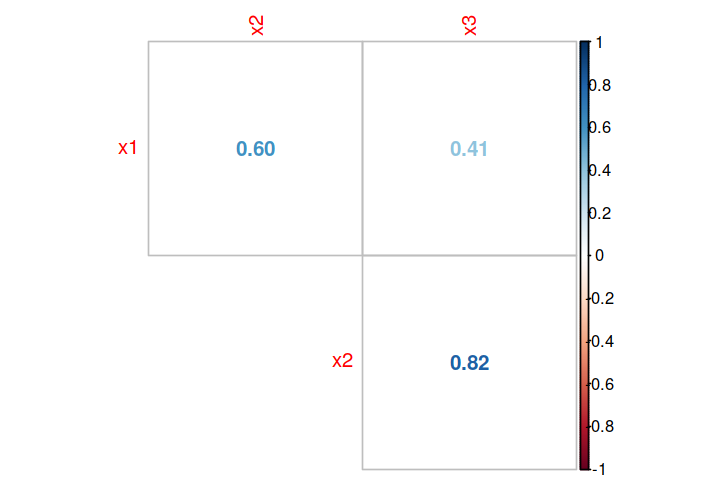

In [11]:
corrplot(cor(data), method='number', type='upper', diag = FALSE)

In [12]:
level <- c(1,2,3)
adj   <- K2(nodes, level, upbound, data)

Node: x1 	-> Parents of x1 	π 1 = Ø 
Node: x2 	-> Parents of x2 	π 2 = x1 
Node: x3 	-> Parents of x3 	π 3 = x2 
Cooper-Herskovits score (ABS): 1.992 



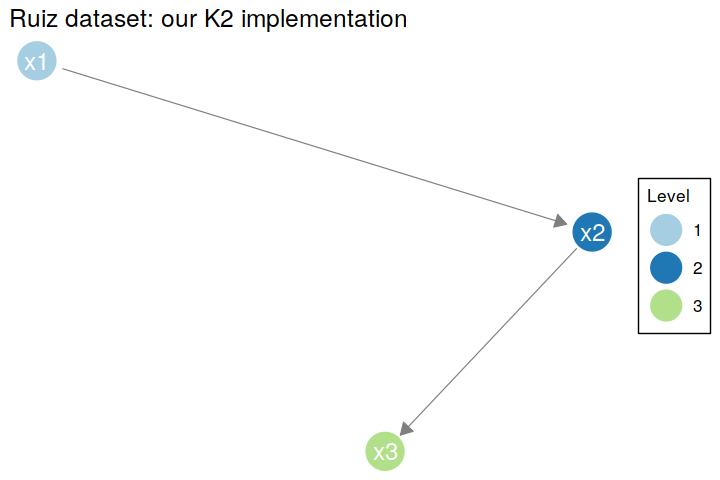

In [13]:
plotGraph(adj, 10, 5, palette='Paired', title='Ruiz dataset: our K2 implementation')

We can see that the algorithm works correctly, leading us to the expected topology. 

In the following, we test the importance of choosing an appropriate ordering for the network's nodes by running the algorithm with all possible permutations of the ordering and computing the global score for each case.  

In [14]:
for (level in permn(1:3)){
    cat('Permutation:', level,'\n')
    K2(nodes, level, upbound, data)
}

Permutation: 1 2 3 
Node: x1 	-> Parents of x1 	π 1 = Ø 
Node: x2 	-> Parents of x2 	π 2 = x1 
Node: x3 	-> Parents of x3 	π 3 = x2 
Cooper-Herskovits score (ABS): 1.992 

Permutation: 1 3 2 
Node: x1 	-> Parents of x1 	π 1 = Ø 
Node: x2 	-> Parents of x2 	π 2 = x3 
Node: x3 	-> Parents of x3 	π 3 = x1 
Cooper-Herskovits score (ABS): 2.077 

Permutation: 3 1 2 
Node: x1 	-> Parents of x1 	π 1 = x2 
Node: x2 	-> Parents of x2 	π 2 = Ø 
Node: x3 	-> Parents of x3 	π 3 = x2 
Cooper-Herskovits score (ABS): 1.992 

Permutation: 3 2 1 
Node: x1 	-> Parents of x1 	π 1 = x2 
Node: x2 	-> Parents of x2 	π 2 = x3 
Node: x3 	-> Parents of x3 	π 3 = Ø 
Cooper-Herskovits score (ABS): 1.989 

Permutation: 2 3 1 
Node: x1 	-> Parents of x1 	π 1 = x3 
Node: x2 	-> Parents of x2 	π 2 = x3 
Node: x3 	-> Parents of x3 	π 3 = Ø 
Cooper-Herskovits score (ABS): 2.074 

Permutation: 2 1 3 
Node: x1 	-> Parents of x1 	π 1 = x2 
Node: x2 	-> Parents of x2 	π 2 = Ø 
Node: x3 	-> Parents of x3 	π 3 = x2 
Cooper-

The permutation with the highest score does not correspond to the correct topology. <br>
This hints that K2 may not be efficient in finding the most probable bayesian network structure without providing some *a priori* information on the ordering of the nodes.

<a id='asia'></a>
### 4.2 `bnstruct `'s `asia` dataset

Several reference Bayesian networks are commonly used in literature as benchmarks. They are available in different formats from several sources, the most famous one being the Bayesian network repository; a collection and a detailed description for many networks can be found [here](https://www.bnlearn.com/bnrepository). All dataset used from now on refer to that page.

We first concentrate on the toy dataset Asia, contained in the [bnstruct library](https://cran.r-project.org/web/packages/bnstruct/bnstruct.pdf).
It investigates possible correlations among the following:
- **Asia**: recent visit to Asia
- **Tub**: tuberculosis
- **Smoke**: smoking
- **LungCan**: lung cancer
- **Bronch**: bronchitis
- **Either**: either lung cancer or bronchitis
- **X-ray**: chest X-ray
- **Dysp**: Shortness-of-breath (dyspnoea)

As for what concerns the ordering of the nodes, it is taken from the image below:


<img align='center' src='https://www.bnlearn.com/bnrepository/asia/asia.png' alt='Drawing' style='width:400px;'/>

In [32]:
data <- asia()

data <- as.data.frame(data@raw.data)
data <- data %>% sapply(as.integer) %>% data.table
data <- data - 1

nodes <- c('Asia', 'Tub', 'Smoke', 'LungCan', 'Bronch', 'Either', 'X-ray', 'Dysp')
colnames(data) <- nodes
level <- c(1,2,1,2,3,3,4,4)
head(data)

upbound <- 2
r_i <- r(data)
cat('r_i:\n\n',r_i)

Asia,Tub,Smoke,LungCan,Bronch,Either,X-ray,Dysp
1,1,0,0,0,1,0,1
1,0,0,0,0,0,1,0
0,0,1,0,0,0,1,0
1,0,1,0,0,0,1,0
1,0,1,0,0,0,0,1
1,0,1,0,0,0,1,1


r_i:

 2 2 2 2 2 2 2 2

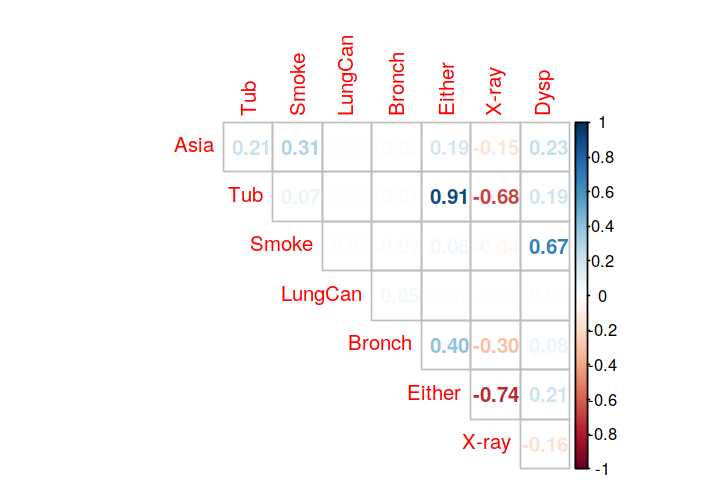

In [16]:
corrplot(cor(data), method='number', type='upper', diag = FALSE)

In [17]:
adj <- K2(nodes, level, upbound, data)

Node: Asia 	-> Parents of Asia 	π 1 = Ø 
Node: Tub 	-> Parents of Tub 	π 2 = Asia 
Node: Smoke 	-> Parents of Smoke 	π 3 = Ø 
Node: LungCan 	-> Parents of LungCan 	π 4 = Ø 
Node: Bronch 	-> Parents of Bronch 	π 5 = LungCan 
Node: Either 	-> Parents of Either 	π 6 = LungCan Tub 
Node: X-ray 	-> Parents of X-ray 	π 7 = Either 
Node: Dysp 	-> Parents of Dysp 	π 8 = Either Smoke 
Cooper-Herskovits score (ABS): 2.356 



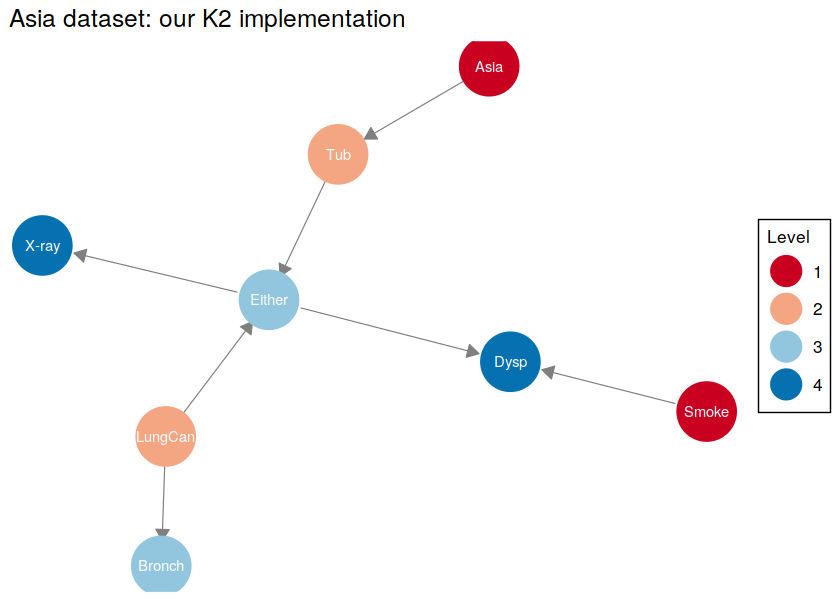

In [18]:
options(repr.plot.width=7, repr.plot.height=5)
plotGraph(adj, 16, 3, title='Asia dataset: our K2 implementation')

We can see that our learned network is mostly similar to the original one, except for the following differences:
- **LungCan** has no parent;
- **Bronch** does not have **Smoke** as parent but has **LungCan** instead;
- **Dysp** has **Smoke** as parent instead of **Bronch**.

In [19]:
p <- Pcond(data, nodes, adj)

In [20]:
printPcond(adj, p, NULL, 'Asia', NULL, 1)

P( Asia = 1 ) = 0.505 ± 2e-05

In [21]:
printPcond(adj, p, 'Either', 'X-ray', 1, 0)

P( X-ray = 0 |( Either ) = ( 1 )) = 0.979 ± 0.005

In [22]:
printPcond(adj, p, c('Tub','LungCan'), 'Either', c(1, 0), 1)

P( Either = 1 |( Tub LungCan ) = ( 1 0 )) = 0.998 ± 0.002

<a id='child'></a>
### 4.3 `bnstruct `'s `child` dataset

We now concentrate on the toy dataset Child, contained in the bnstruct library. It investigates the incidence and presentation of $6$ possible diseases that would lead to a *blue baby*. <br>
The node *Disease* includes six possible conditions, assumed mutually exclusive and exhaustive, that lead to particularly 'blue' babies. The graph represents, for example, that the level of oxygen in the lower body (*LowerBodyO2*) is directly related to the underlying level when breathing oxygen (*HypoxiaInO2*) and whether the hypoxia is equally distributed around the body (*HypDistrib*). 

The number of nodes is equal to $20$ and each node has a different cardinality. <br>
As for what concerns the ordering of the nodes, it is taken from the image below:

<img align='center' src='https://www.bnlearn.com/bnrepository/child/child.png' alt='Drawing' style='width:500px;'/>

In [23]:
data <- child()
data <- bnstruct::impute(data)

bnstruct :: performing imputation ...
bnstruct :: imputation finished.


In [24]:
data <- as.data.frame(data@imputed.data)
data <- data %>% sapply(as.integer) %>% data.table
data <- data - 1

nodes <- c('BA', 'DIS', 'AGE', 'LVH', 'DF', 'CM', 'LP', 'LF', 'S', 'HD',
           'HO2', 'CO2', 'CXR', 'G', 'LVHR', 'LBO2', 'RUQO2', 'CO2R', 'XRR', 'GR')
colnames(data) <- nodes
level <- c(1,2,4,3,3,3,3,3,3,4,4,4,4,4,4,5,5,5,5,5)
head(data)

upbound <- 2
r_i <- r(data)
cat('r_i:\n\n',r_i)

BA,DIS,AGE,LVH,DF,CM,LP,LF,S,HD,HO2,CO2,CXR,G,LVHR,LBO2,RUQO2,CO2R,XRR,GR
1,2,2,1,0,2,0,0,1,0,0,0,0,1,1,1,2,1,0,1
1,3,1,0,0,1,0,1,1,0,1,0,1,1,0,1,1,0,1,1
1,2,0,1,0,2,0,1,1,0,1,1,1,1,1,0,1,0,1,1
1,3,0,0,0,2,0,0,1,0,2,0,0,1,0,2,0,0,0,1
1,1,0,1,1,3,0,0,0,0,2,0,0,1,1,0,0,0,1,1
1,1,0,1,0,3,0,2,1,0,2,0,2,1,1,1,0,0,2,1


r_i:

 2 6 3 2 3 4 3 3 2 2 3 3 5 2 2 3 3 2 5 2

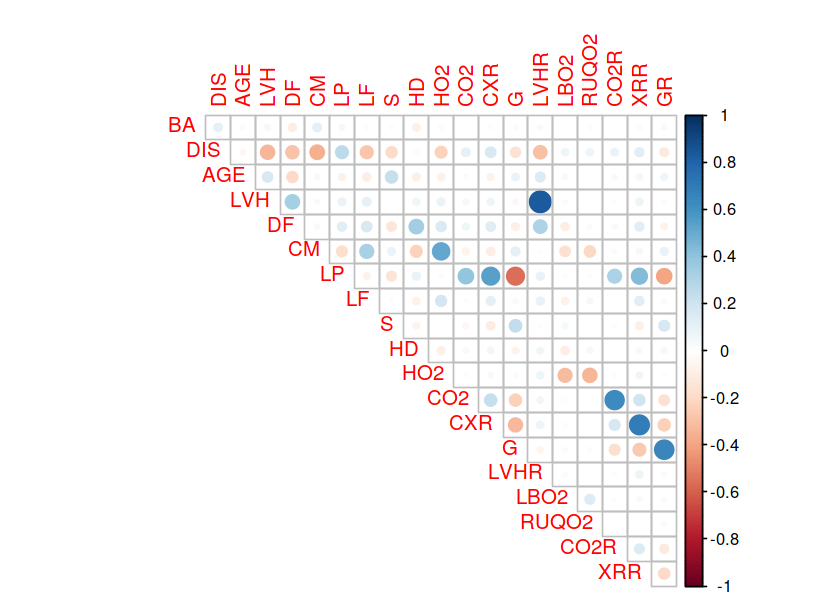

In [25]:
corrplot(cor(data), type='upper', diag = FALSE)

In [26]:
adj <- K2(nodes, level, upbound, data)

Node: BA 	-> Parents of BA 	π 1 = Ø 
Node: DIS 	-> Parents of DIS 	π 2 = BA 
Node: AGE 	-> Parents of AGE 	π 3 = S DIS 
Node: LVH 	-> Parents of LVH 	π 4 = DIS 
Node: DF 	-> Parents of DF 	π 5 = DIS 
Node: CM 	-> Parents of CM 	π 6 = DIS 
Node: LP 	-> Parents of LP 	π 7 = DIS 
Node: LF 	-> Parents of LF 	π 8 = DIS 
Node: S 	-> Parents of S 	π 9 = DIS 
Node: HD 	-> Parents of HD 	π 10 = CM DF 
Node: HO2 	-> Parents of HO2 	π 11 = LP CM 
Node: CO2 	-> Parents of CO2 	π 12 = LP 
Node: CXR 	-> Parents of CXR 	π 13 = LP LF 
Node: G 	-> Parents of G 	π 14 = S LP 
Node: LVHR 	-> Parents of LVHR 	π 15 = DIS LVH 
Node: LBO2 	-> Parents of LBO2 	π 16 = HD HO2 
Node: RUQO2 	-> Parents of RUQO2 	π 17 = HO2 
Node: CO2R 	-> Parents of CO2R 	π 18 = CO2 
Node: XRR 	-> Parents of XRR 	π 19 = CXR 
Node: GR 	-> Parents of GR 	π 20 = G 
Cooper-Herskovits score (ABS): 11.93 



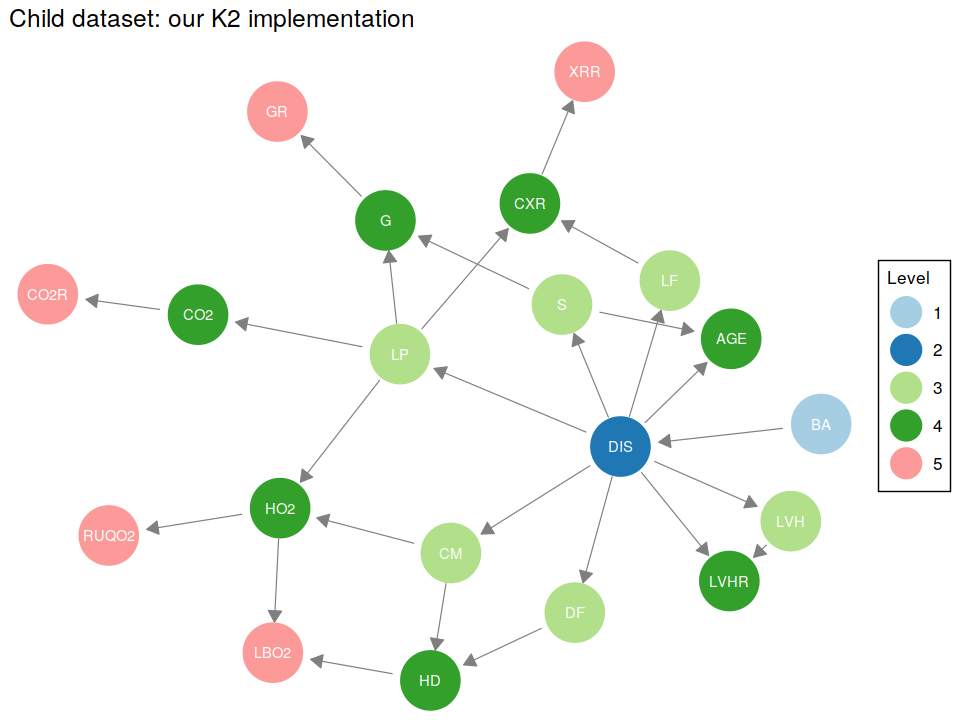

In [27]:
options(repr.plot.width=8, repr.plot.height=6)
plotGraph(adj, 16, 3, palette='Paired', title='Child dataset: our K2 implementation')

In this case the results are better than in `asia` since the only difference is that **LVHR** has as parent **DIS** which should not be present according to the original structure.

In [28]:
p <- Pcond(data, nodes, adj)

In [29]:
printPcond(adj, p, NULL, 'BA', NULL, 0)

P( BA = 0 ) = 0.086 ± 2e-05

In [30]:
printPcond(adj, p, c('S','DIS'), 'AGE', c(0, 0), 0)

P( AGE = 0 |( S DIS ) = ( 0 0 )) = 0.907 ± 0.03

<a id='performances'></a>
[Index](#index)
## 5. Code performances

We now want to test how the code's performance scales as the size of the dataset increases. In order to do so, let's refer to the Asia dataset, which stores 10,000 cases and see how much time it takes to perform the algorithm as we increase the number of selected cases taken into consideration. <br>
We define the following functions:

#### `time`

* **Input**
    - `fun`: the function whose perfomance are to be timed   
    
* **Output**
    - The time needed to run the function
    
We simply make use of the built-in R function `Sys.time()` before and after the call of `fun` to calculate the temporal interval required to run the code.

In [31]:
time <- function(fun){
    start <- Sys.time()
    capture.output(fun)
    end   <- Sys.time()
    return(round(end - start,2))
}

In [33]:
cas <- seq(from = 100, to = nrow(data), by = 500)

n <- length(cas)
ts <- double(n)
for (i in 1:n){
    ci <- cas[i]
    ts[[i]] <- time(K2(nodes, level, upbound, data[1:ci,])) %>% as.numeric
}

dt <- data.table(cas, ts)

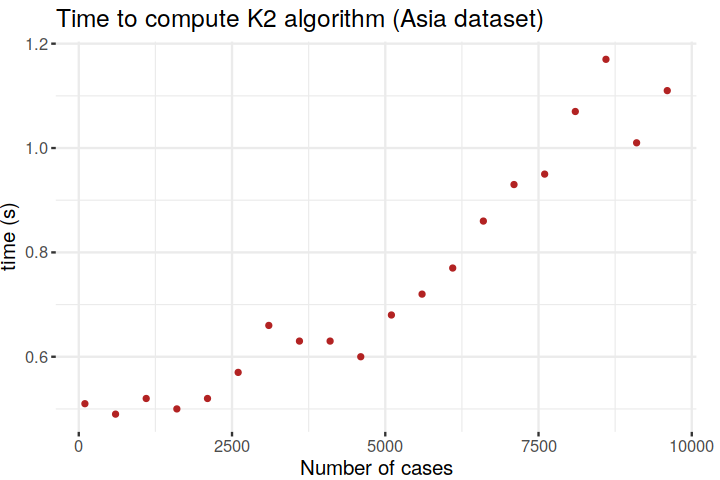

In [34]:
options(repr.plot.width=6, repr.plot.height=4)

ggplot(dt, aes(x=cas, y=ts)) + geom_point(color='firebrick', size = 1) +
labs(title='Time to compute K2 algorithm (Asia dataset)', x='Number of cases', y='time (s)') +
theme(plot.margin = margin(.2, .5, 0, 0, 'cm'))

<a id='bnlearn'></a>
[Index](#index)
## 6. K2 in `bnlearn`: `asia` and `child` datasets

As a comparison, we now investigate how K2 performs using the implementation of a hill climbing greedy search with Cooper-Herskovits score (K2 score), contained in `bnlearn`. <br>
We consider as datasets Asia and Child. 

The employed function is `hc`, as cited in the relative [documentation](https://cran.r-project.org/web/packages/bnlearn/bnlearn.pdf)
>a hill climbing greedy search that explores the space of the directed acyclic graphs by single-arc addition, removal and reversals; with random restarts to avoid local optima. The optimized implementation uses score caching, score decomposability and score equivalence to reduce the number of duplicated tests.

One can choose the kind of score to use as a parameter (here `K2`), along with other specifications, such as the maximum number of parents (`maxp`). It does not accept as a parameter the ordering of the nodes.

We report here the structure of the function for completion:
```R
hc(x, start = NULL, whitelist = NULL, blacklist = NULL, score = NULL, ...,
   debug = FALSE, restart = 0, perturb = 1, max.iter = Inf, maxp = Inf, optimized = TRUE)
```
Returns: An object of class `bn`

<a id='abnlearn'></a>
### 6.1 `asia` dataset

In [35]:
bn.asia <- asia()
df.asia <- as.data.frame(raw.data(bn.asia))
colnames(df.asia) <- variables(bn.asia)
df.asia <- df.asia %>% sapply(as.factor) %>% data.frame

In [36]:
bn.asia.k2 <- hc(df.asia, score='k2', maxp=2)
bn.asia.k2$nodes

$Asia
$Asia$mb
[1] "Tubercolosys" "Smoke"       

$Asia$nbr
[1] "Tubercolosys" "Smoke"       

$Asia$parents
[1] "Tubercolosys" "Smoke"       

$Asia$children
character(0)


$Tubercolosys
$Tubercolosys$mb
[1] "Asia"       "Smoke"      "Bronchitis" "Either"     "Dyspnea"   

$Tubercolosys$nbr
[1] "Asia"    "Either"  "Dyspnea"

$Tubercolosys$parents
character(0)

$Tubercolosys$children
[1] "Asia"    "Either"  "Dyspnea"


$Smoke
$Smoke$mb
[1] "Asia"         "Tubercolosys" "Either"       "Dyspnea"     

$Smoke$nbr
[1] "Asia"    "Either"  "Dyspnea"

$Smoke$parents
[1] "Either"  "Dyspnea"

$Smoke$children
[1] "Asia"


$LungCancer
$LungCancer$mb
[1] "Bronchitis"

$LungCancer$nbr
[1] "Bronchitis"

$LungCancer$parents
character(0)

$LungCancer$children
[1] "Bronchitis"


$Bronchitis
$Bronchitis$mb
[1] "Tubercolosys" "LungCancer"   "Either"       "Dyspnea"     

$Bronchitis$nbr
[1] "LungCancer" "Either"     "Dyspnea"   

$Bronchitis$parents
[1] "LungCancer"

$Bronchitis$children
[1] "Either"  "Dyspnea"


$Either
$Either$mb
[1] "Tubercolosys" "Smoke"        "Bronchitis"   "X.ray"        "Dyspnea"     

$Either$nbr
[1] "Tubercolosys" "Smoke"        "Bronchitis"   "X.ray"       

$Either$parents
[1] "Tubercolosys" "Bronchitis"  

$Either$children
[1] "Smoke" "X.ray"


$X.ray
$X.ray$mb
[1] "Either"

$X.ray$nbr
[1] "Either"

$X.ray$parents
[1] "Either"

$X.ray$children
character(0)


$Dyspnea
$Dyspnea$mb
[1] "Tubercolosys" "Smoke"        "Bronchitis"   "Either"      

$Dyspnea$nbr
[1] "Tubercolosys" "Smoke"        "Bronchitis"  

$Dyspnea$parents
[1] "Tubercolosys" "Bronchitis"  

$Dyspnea$children
[1] "Smoke"

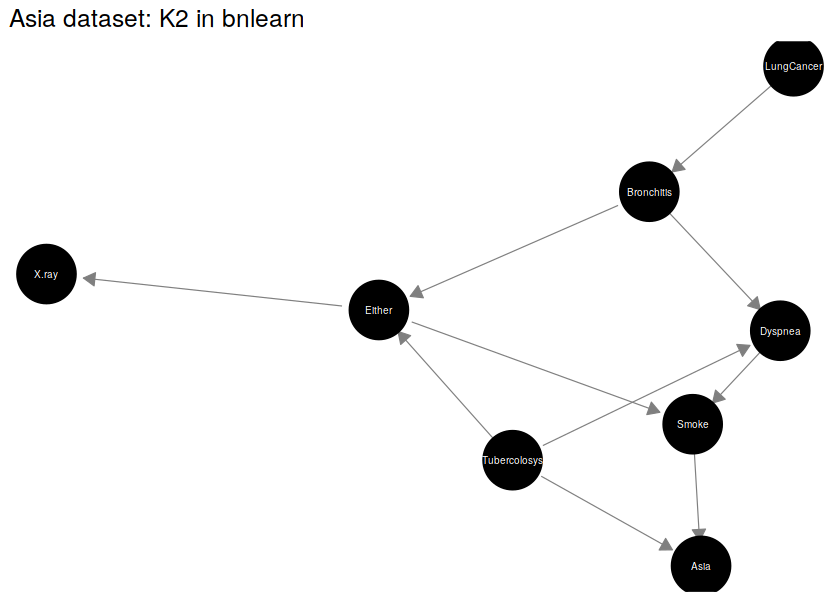

In [37]:
options(repr.plot.width=7, repr.plot.height=5)
ggnet2(as.igraph(bn.asia.k2), size=16, label=TRUE, label.size=2, color='black',
       label.color='white', arrow.size=8, arrow.gap=0.05) + labs(title='Asia dataset: K2 in bnlearn')

<a id='cbnlearn'></a>
### 6.2 `child` dataset

In [38]:
bn.child <- bnstruct::impute(child())
df.child <- as.data.frame(bn.child@imputed.data)
colnames(df.child) <- variables(bn.child)
df.child <- df.child %>% sapply(as.factor) %>% data.frame

bnstruct :: performing imputation ...
bnstruct :: imputation finished.


In [39]:
bn.child.k2 <- hc(df.child, score='k2', maxp=2)

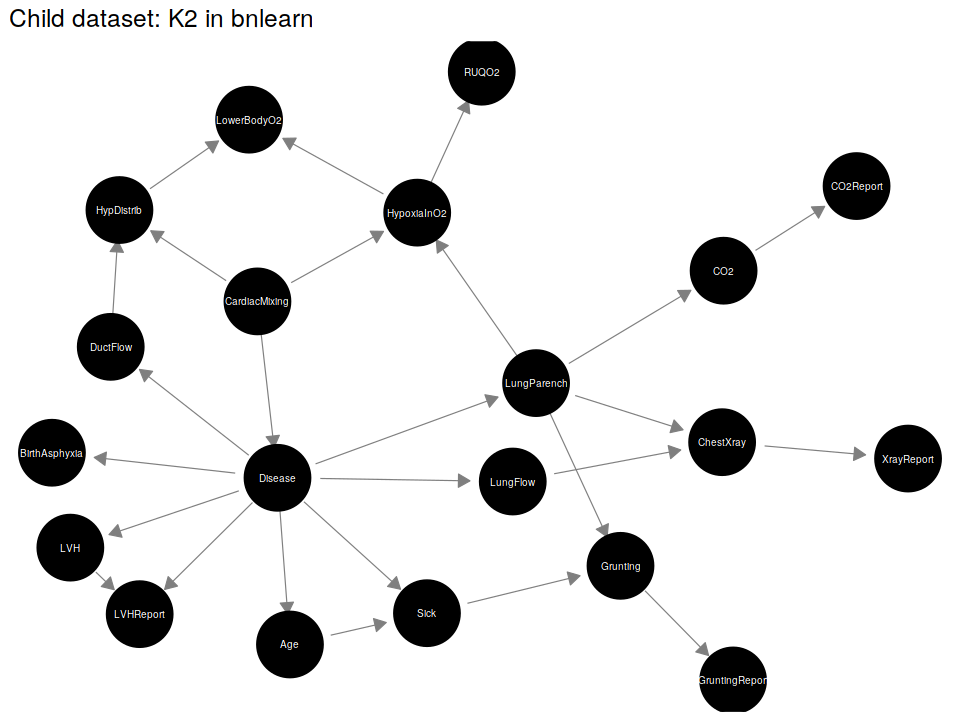

In [40]:
options(repr.plot.width=8, repr.plot.height=6)
ggnet2(as.igraph(bn.child.k2), size=18, label=TRUE, label.size=2, color='black',
       label.color='white', arrow.size=8, arrow.gap=0.05) + labs(title='Child dataset: K2 in bnlearn')

<a id='k2bnstruct'></a>
[Index](#index)
## 7. Implementing K2 in `bnstruct`

In order to implement the K2 algorithm inside a package, one can choose between two different approaches depending on what the intended use is.
- **Soft way**: copy and modify a local version of the package for personal use only. In this case one does not have to worry about dependecies from other packages and back-compatibility with the other functions. Furthermore, one can ignore style cohesion and CRAN requisites. In a nutshell:
    - Download the package as a `.tar` file from the CRAN repository;
    - All the relevant files with the different algorithms are contained in the `R` folder. Open and modify the corresponding file, adding your functions, and save it under the same name. As a result, a package folder that contains an updated version of the `.R` file is created.
    - Finally, use the build function of the `devtools` package to create a single bundled `.tar` file from this updated package folder. Specifically, one may simply use: 
```R 
build(pkg='path1/package', path='~path2/package_new.tar', manual=FALSE, binary=FALSE)
```
where path1 navigates to the place of the updated package folder and path2 says where the bundled package shall be stored. Install the updated package archive file in RStudio via
```R
install.packages('~path2/package_name_new.tar', repos = NULL, type='source')
```
- **Hard way**: contribute to the official version of the package on CRAN.
    + First of all, one needs to check that the owners of the package accept contributions and in such case how they handle them: often projects will have a `CONTRIBUTING.md` document that has instructions for contributing to the project. These are guidelines the maintainers would like contributors to adhere to and exist to make the process flow more smoothly. In the specific case of `bnstruct` no such document is provided on the [GitHub repository](https://github.com/sambofra/bnstruct).
    + As for what concerns the code to write the first thing to notice for bnstruct is that the package works with S4 objects. In our implementation of the algorithm however we worked with S3 objects, which markedly differ from S4 classes; S4 formally defines the representation and inheritance for each class, and has multiple dispatch.
    + Even if we would only wish to add the K2 scoring function to the list of the possible scoring functions implemented in the `learn.network` method we would need to rewrite the function `f` in C; indeed, the scoring functions used in this method are all written in C and contained in the file `util.c` under the `src` directory.
    + Moreover, policies for when a binary package is distributed (listed from the [CRAN page](https://cran.r-project.org/web/packages/policies.html)) are:
        - All its package dependencies on CRAN are available for the operating system.
        - Any external software needed can easily be installed on the build machine for all the sub-architectures: it must not depend on specific versions, nor should the installed binary do.
        - It passes `R CMD` check without error for all the available sub-architectures.

<a id='out'></a>
[Index](#index)
## 8. Conclusion and Outlook

One of the main issues with the K2 algorithm is that it is not robust, since it achieves different network structure if node orderings are permuted. 
Therefore, choosing the appropriate sequential node ordering (i.e. what we call the node's level) for the input of the K2 algorithm is a challenging task. In our workcase, this wasn't a big issue: we already knew what was the output we were expecting and we were testing to see if our implementation was properly working; from the beginning we knew what an appropriate node ordering would be.<br>
However, in general, one does not have this information: choosing suitable sequential node ordering for the input of the K2 algorithm is then a challenging task.<br>
In [**5**], the authors test some deterministic methods for node ordering, already existing in literature. Their effectiveness was tested through the Asia, Alarm, Car, and Insurance networks.<br>
A brief summary of the methods they used is the following (see the paper for further details): 
- the SORDER algorithm (uses the correlation matrix) 
- factor analysis (uses the correlation matrix)
- the entropy (uses the uncertainty between variables)
- the conditional entropy (uses the uncertainty between variables) 
- the MI (uses dependency between variables for the node ordering)
- scoring method (selects a node ordering that maximizes the BIC score)

In order to evaluate the performance of the proposed algorithms, the results are compared with those obtained from $N = 103$ random permutations.<br>
Results indicate that the methods based on the concept of mutual information and entropy are suitable for finding a sequential node ordering and considerably improve the precision of network inference.

More recently, a novel algorithm has been introduced, namely Order Independent PC-based algorithm using Quantile value (OIPCQ). [**6**] <br>
Such algorithm improves the accuracy of the learning process of GRNs (Gene Regulatory Networks) and solves the order dependency issue. The method was developed in the contest of inferring gene regulatory network for conditional independence tests.

***
<a id='ref'></a>
[Index](#index)
## 9. References

[**1**] G. F. Cooper and E. Herskovits, *A Bayesian Method for the Induction of Probabilistic Networks from Data*, Machine Learning 9, (1992) 309

[**2**] C. Ruiz, *Illustration of the K2 Algorithm for learning Bayes Net Structures*, http://web.cs.wpi.edu/~cs539/s11/Projects/k2_algorithm.pdf

[**3**] A. Franzin et al., *bnstruct: an R package for Bayesian Network structure learning in the presence of missing data*, Bioinformatics 33(8) (2017) 1250

[**4**] F. Sambo and A. Franzin, *bnstruct: an R package for Bayesian Network Structure Learning with missing data*, December 12, 2016

[**5**] R. Aghdam et al., *Some node ordering methods for the K2 algorithm Computational Intelligence*, Wiley, 2018, 35, 42-58, https://doi.org/10.1111/coin.12182

[**6**] S. H. Mahmoodi et al., *An order independent algorithm for inferring gene regulatory network using quantile value for conditional independence tests*, Scientific Reports, Springer Science and Business Media LLC, 2021, 11 https://doi.org/10.1038/s41598-021-87074-5

- inserire match/non match nostre reti quelle imparate da bnlearn